Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [X] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition.
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [X] Begin with baselines for classification.
- [X] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [X] Get your validation accuracy score.
- [X] Get and plot your feature importances.
- [X] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [X] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [X] Add your own stretch goal(s) !
- [X] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

## Do train/validate/test split with the Tanzania Waterpumps data.

In [123]:
import pandas as pd
pd.options.display.max_rows = 15
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [112]:
# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

## Begin with baselines for classification.

In [124]:
train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

The majority class occurs with 54.31% frequency, so this is our baseline.

## Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [114]:
import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

## Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.

In [125]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
# val = wrangle(val)
test = wrangle(test)

## Select features.

In [126]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [127]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
# X_val = val[features]
# y_val = val[target]
X_test = test[features]

## Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [148]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from time import time

In [150]:
# Fit pipeline on GridSearchCV
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    # DecisionTreeClassifier(random_state=42)
    RandomForestClassifier(n_estimators=100, random_state=42)
)

param_grid = {
    # 'decisiontreeclassifier__max_depth': range(16,19)
    'randomforestclassifier__max_depth': range(16,19)
}
search = GridSearchCV(pipe,
                      param_grid=param_grid,
                      n_jobs=-1,
                      iid=False,
                      cv=5)

# Fit the cross-validation on train
t0 = time()
search.fit(X_train, y_train)
print(f'Done in {(time()-t0):0.3f}s\n')
print(f'Best parameters (CV score={search.best_score_:0.3f}):')
print(search.best_params_)

Done in 206.433s

Best parameter (CV score=0.801):
{'randomforestclassifier__max_depth': 18}


In [159]:
# Set the best parameters and fit to train
t0 = time()
# pipe.set_params(decisiontreeclassifier__max_depth=17)
pipe.set_params(randomforestclassifier__max_depth=18)
pipe.fit(X_train, y_train)
print(f'Done in {(time()-t0):0.3f}s\n')

Done in 24.442s



## Get your validation accuracy score.

In [160]:
# Score on train, val
print('Train Accuracy:', pipe.score(X_train, y_train))
# print('Validation Accuracy:', pipe.score(X_val, y_val))

Train Accuracy: 0.8745117845117845


In [161]:
search.cv_results_

{'mean_fit_time': array([51.94253163, 41.91532717, 32.9806181 ]),
 'std_fit_time': array([4.85277829, 1.84095379, 5.81511157]),
 'mean_score_time': array([2.36513243, 2.55806499, 1.87732053]),
 'std_score_time': array([0.2708099 , 0.15295565, 0.26902367]),
 'param_randomforestclassifier__max_depth': masked_array(data=[16, 17, 18],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'randomforestclassifier__max_depth': 16},
  {'randomforestclassifier__max_depth': 17},
  {'randomforestclassifier__max_depth': 18}],
 'split0_test_score': array([0.79488259, 0.79934349, 0.80464607]),
 'split1_test_score': array([0.79387257, 0.79505092, 0.79858598]),
 'split2_test_score': array([0.7973064 , 0.80092593, 0.80244108]),
 'split3_test_score': array([0.79031987, 0.79478114, 0.79873737]),
 'split4_test_score': array([0.79365213, 0.79643038, 0.79904024]),
 'mean_test_score': array([0.79400671, 0.79730637, 0.80069015]),
 'std_test_score': array([0

## Get and plot your feature importances.

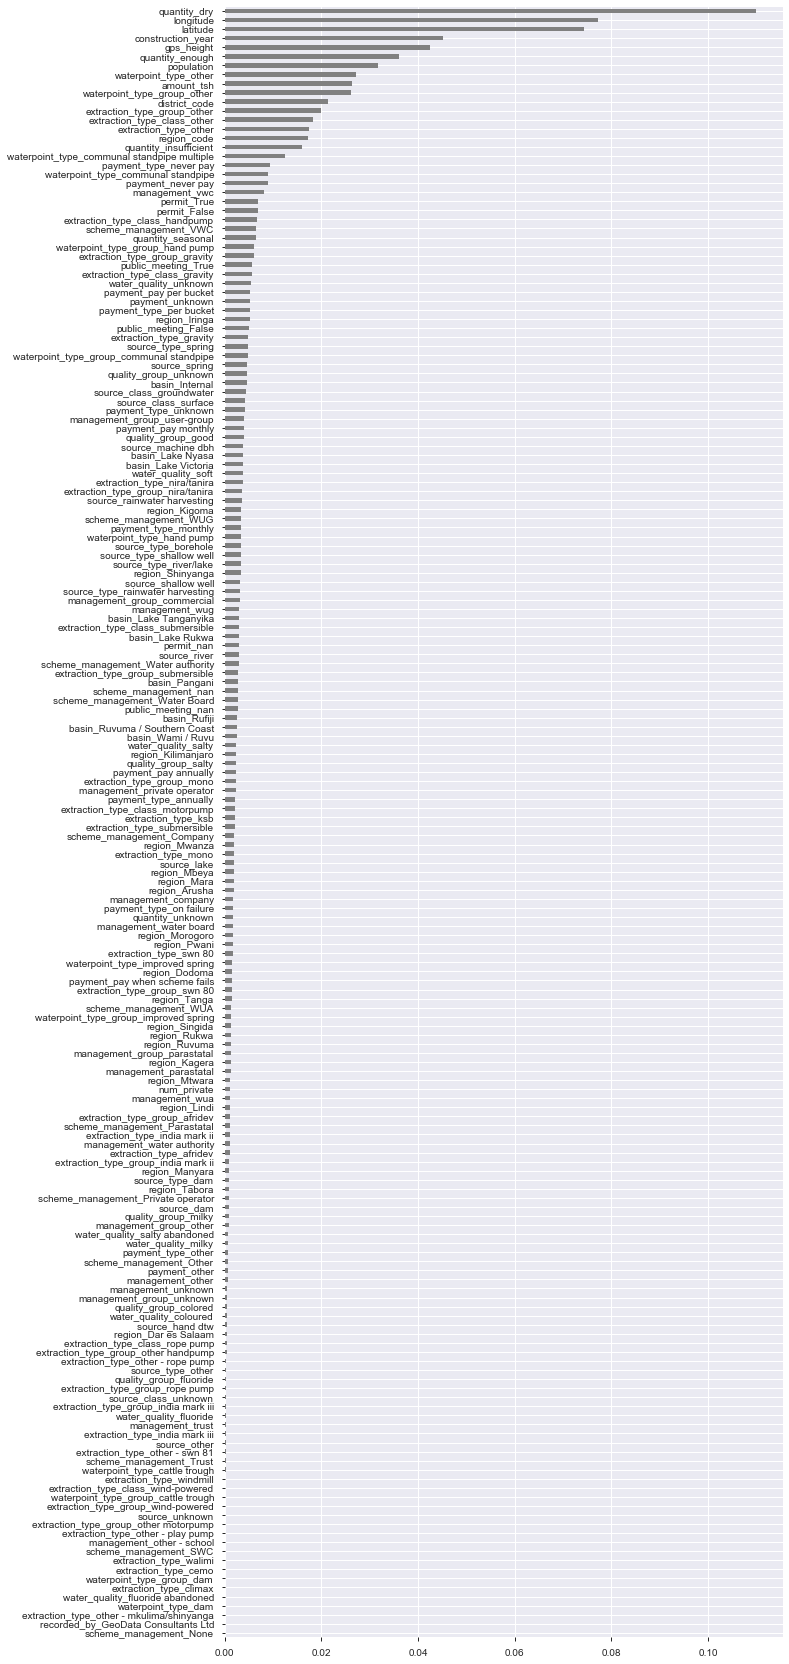

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get the feature importances
# model = pipe.named_steps['decisiontreeclassifier']
model = pipe.named_steps['randomforestclassifier']
encoder = pipe.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)

# Plot the feature importances
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

## Submit your predictions to our Kaggle competition.

In [158]:
# Generate the Kaggle predictions
y_pred = pipe.predict(X_test)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index
submission = sample_submission.copy()
submission['status_group'] = y_pred

filename = 'submission.csv'
submission.to_csv(filename, index=False)

In [ ]:
# Pandas Profiling can be very slow with medium & large datasets.
# These parameters will make it faster.
# https://github.com/pandas-profiling/pandas-profiling/issues/222

import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report